In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Apr 11 19:43:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from datetime import datetime

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import *
from sklearn.metrics import *

In [0]:
artists = pd.read_csv('/content/drive/My Drive/Artist to Artwork/best-artworks-of-all-time/artists.csv')

artists = artists.sort_values(by=['paintings'],ascending=False)

artists_top = artists[artists['paintings']>=200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings

In [0]:
class_weights = artists_top['class_weight'].to_dict()

updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

images_dir = '/content/drive/My Drive/Artist to Artwork/best-artworks-of-all-time/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [40]:
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   #shear_range=0.7,
                                   zoom_range=0.7,
                                   #horizontal_flip=True,
                                   #vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


In [41]:
start_train_time = datetime.now()

# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True


# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)


optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto') #restore_best_weights=True

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

checkpoint_path = '/content/drive/My Drive/Artist to Artwork/checkpoints/cp.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=5)

model.save_weights(checkpoint_path.format(epoch=0))

print("Training Model 1")
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr,cp_callback],
                              # use_multiprocessing=True,
                              # workers=32,
                              class_weight=class_weights
                             )



for layer in model.layers:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

print("Training Model 2")
n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop,cp_callback],
                              # use_multiprocessing=True,
                              # workers=32,
                              class_weight=class_weights
                             )


#model.save_weights('model_checkpoint2')

train_end_time = datetime.now()

total_time = train_end_time - start_train_time 

if tf.test.gpu_device_name():
    print(f"Time taken to train model with GPU --> {total_time}")
else:
    print(f"Time taken to train model with CPU --> {total_time}")

Training Model 1
Epoch 1/10
215/215 [==============================] - 132s 612ms/step - loss: 3.9072 - accuracy: 0.4776 - val_loss: 2.4499 - val_accuracy: 0.0896 - lr: 1.0000e-04
Epoch 2/10
215/215 [==============================] - 130s 604ms/step - loss: 3.0191 - accuracy: 0.6779 - val_loss: 2.6531 - val_accuracy: 0.0483 - lr: 1.0000e-04
Epoch 3/10
215/215 [==============================] - 129s 602ms/step - loss: 2.6904 - accuracy: 0.7340 - val_loss: 2.6365 - val_accuracy: 0.0719 - lr: 1.0000e-04
Epoch 4/10
215/215 [==============================] - 131s 611ms/step - loss: 2.3859 - accuracy: 0.7768 - val_loss: 2.1698 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/10
215/215 [==============================] - ETA: 0s - loss: 2.1994 - accuracy: 0.7940
Epoch 00005: saving model to /content/drive/My Drive/Artist to Artwork/checkpoints/cp.ckpt
215/215 [==============================] - 135s 626ms/step - loss: 2.1994 - accuracy: 0.7940 - val_loss: 1.3191 - val_accuracy: 0.6568 - lr: 1.0

In [15]:
total_time = train_end_time - start_train_time 
total_time

datetime.timedelta(0, 2819, 460899)

In [0]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

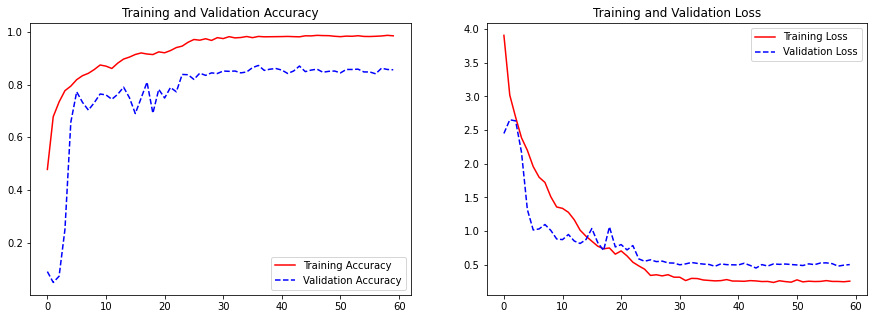

In [43]:
# Plot the training graph
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

In [25]:
# Prediction accuracy on train data
score = model.evaluate(train_generator)
print("Prediction accuracy on train data =", score[1])

   9113/Unknown - 4338s 476ms/step - loss: 0.7071 - accuracy: 0.8439

KeyboardInterrupt: ignored

In [26]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator)
print("Prediction accuracy on CV data =", score[1])

KeyboardInterrupt: ignored

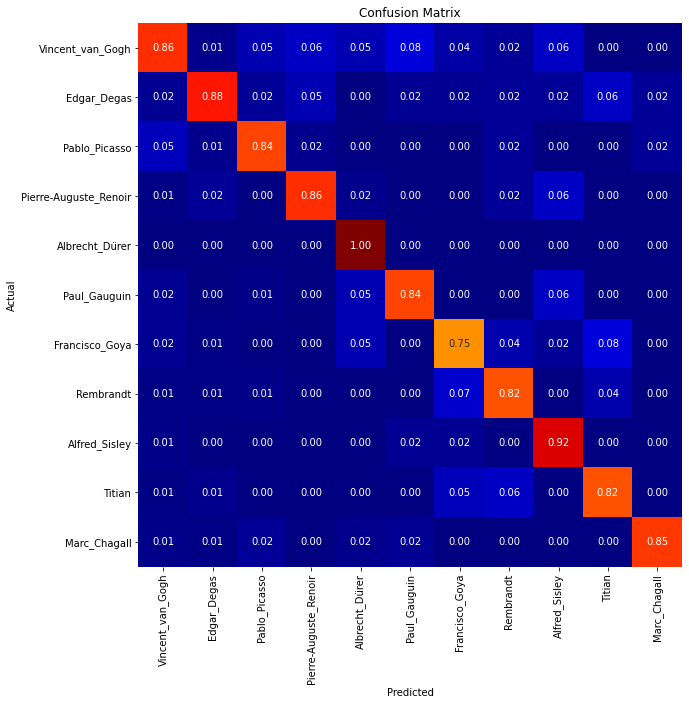

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.86      0.86      0.86       174
          Edgar_Degas       0.91      0.88      0.90       139
        Pablo_Picasso       0.88      0.84      0.86        86
Pierre-Auguste_Renoir       0.88      0.86      0.87        65
      Albrecht_Dürer       0.86      1.00      0.92        65
         Paul_Gauguin       0.87      0.84      0.85        62
       Francisco_Goya       0.80      0.75      0.77        57
            Rembrandt       0.82      0.82      0.82        51
        Alfred_Sisley       0.81      0.92      0.86        51
               Titian       0.82      0.82      0.82        51
         Marc_Chagall       0.95      0.85      0.90        47

             accuracy                           0.86       848
            macro avg       0.86      0.86      0.86       848
         weighted avg       0.86      0.86      0.86       848



In [44]:
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

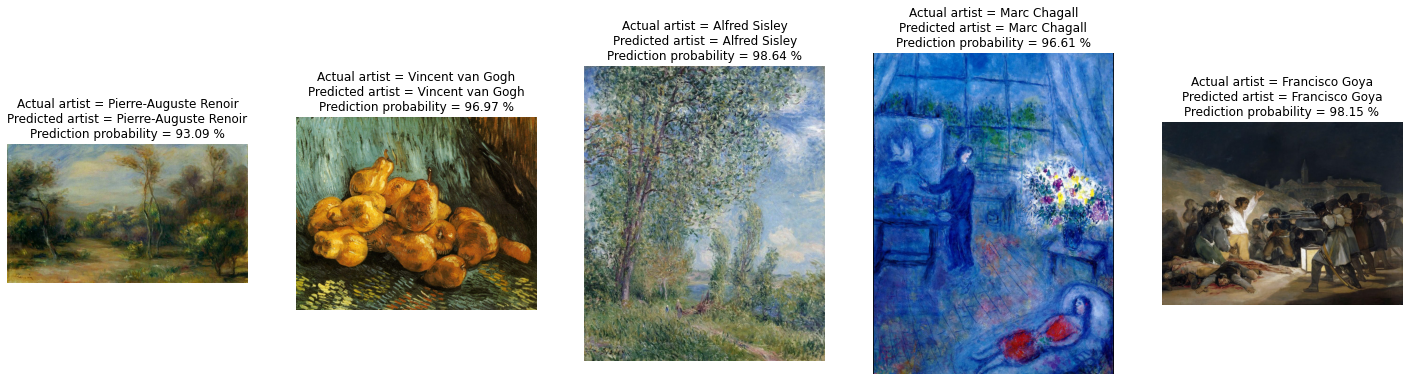

In [45]:
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

Predicted artist = Titian
Prediction probability = 72.94976711273193 %


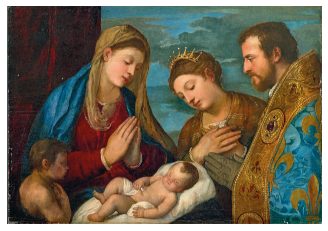

In [46]:
# Predict from web - this is an image of Titian.
# Replace 'url' with any image of one of the 11 artists above and run this cell.
url = 'https://www.dorotheum.com/fileadmin/lot-images/38A181023/hires/tiziano-vecellio-gen.-tizian-werkstatt-6002901.jpg'

import imageio
import cv2

web_image = imageio.imread(url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()